# scANNA Tutorial: Using scANNA's Interpretability for Selecting Most Important Global Features
## For GSE144236 Data

In this notebook, we will go over how to load a pre-trained scANNA model and how to extract the most important (global) genes according to our model's interpretability.

In [1]:
try:
    from nbproject import header
    header(filepath="/home/aheydari/SindiLabTutorials/"
           "scANNA(single-cell Analysis using Neural Attention)/"
           "Global Feature Selection/"
           "scANNA_tutorial_FindingGlobalMarkers_GSE144236.ipynb")

except ModuleNotFoundError:
    print("Please install nbproject (pip install nbproject) to see header"
         "dependencies.")

ℹ️ Assuming editor is Jupyter Lab.


id,ejpJXTbwOgNp
version,0
time_init,2023-03-13 18:19
time_run,2023-03-13 18:19
pypackage,matplotlib==3.5.1 nbproject==0.8.1 numpy==1.23.5 scanna==0.0.2 scanpy==1.9.1 scikit-learn==1.2.0 smashpy==0.1.2 torch==1.13.1 xgboost==1.7.3


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scanna.utilities import *
from scanna import AttentionQuery, scanpy_to_dataloader
import scanpy as sc
import smashpy
from sklearn.metrics import f1_score, accuracy_score
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
import torch
import time
from xgboost import XGBClassifier 

2023-03-13 11:20:04.991594: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 11:20:05.038772: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay
2023-03-13 11:20:05.040900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 11:20:06.325001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
%load_ext autoreload
%autoreload 2

Here we define some general functions for our analyses

In [4]:
def get_logp1_variance(data:np.array)->float:
    """ Function for calculating the variance of a Log(x+1) transformed data"""
    return np.var(np.log(data + 1), axis=0).sum()

def explained_variance_ratio(full_dimension_data:np.array, 
                             train_data:np.array, 
                             test_data:np.array)->float:
    """ Utility function for calculating the fraction of total variance"""
    all_data = np.concatenate((train_data, test_data), axis=0)
    return (get_logp1_variance(all_data) / 
            get_logp1_variance(full_dimension_data))

def measure_performance(X_train:np.array, 
                y_train:np.array, 
                X_test:np.array, 
                y_test:np.array, 
                classifer: NearestCentroid | KNeighborsClassifier | 
                  XGBClassifier, 
                scoring : str = 'weighted', 
                classifier_name : str = None):
    """ Function for automating classification and calculating F1 score"""
    start_time = time.time()
    classifer.fit(X_train, y_train)
    y_pred = classifer.predict(X_test)
    f1_accuracy = f1_score(y_test, y_pred, average=scoring)
    if classifier_name is not None:
        print(f"For {classifier_name} classifier:")
        
    print(f"F1 ({scoring}) Score: {f1_accuracy}")
    print(f"Training and classification time took: {time.time() - start_time}")
    print()
    return f1_accuracy
    

# Define Various Classification Models for Validation

In [5]:
nearest_centroid_classifier=NearestCentroid()

knn_classifier= KNeighborsClassifier(n_neighbors=3, 
                                     n_jobs=-1)

xgboost_classifier = XGBClassifier(n_estimators=50, 
                                   max_depth=2, 
                                   learning_rate=0.09, 
                                   objective='binary:logistic', 
                                   n_jobs=-1)

## Checking Accuracy on All Highly Variable Genes (HVGs)

As a baseline and to see how well scANNA picks the highly variable genes, we will check the accuracy of each classifer on **all** HVGs.

In [6]:
abs_path = "/home/aheydari/"
local_path = "data/scANNA_Data/Benchmarking/"

In [7]:
# label for the dataset folder we want to make
dataset_name = "GSE144236"
# directory for specific dataset
dataset_dir = f"./{dataset_name}" 
# subdir where we store cluster attention and attention means
results = f"./{dataset_name}/results" 
# subdir where we store cluster enrichment plots
plots = f"./{dataset_dir}/plots" 

In [8]:
path_to_data = (f"{abs_path}{local_path}{dataset_name}"
                "_qc_hvg_anno_5k_raw_train_split.h5ad")

adata = sc.read(path_to_data)

adata_train = adata[adata.obs.split=="train"]
adata_test = adata[adata.obs.split=="test"]

labels_train  = adata_train.obs.cluster.to_numpy()
labels_test  = adata_test.obs.cluster.to_numpy()

In [9]:
print("For all 5000 HVGs:")

nc_5k_accuracy = measure_performance(np.array(adata_train.X.todense()), 
                     labels_train.astype(int) ,
                     np.array(adata_test.X.todense()), 
                     labels_test.astype(int), 
                     classifer=nearest_centroid_classifier,
                     classifier_name = "Nearest Centroid",
                     )

knn_5k_accuracy = measure_performance(np.array(adata_train.X.todense()), 
                     labels_train.astype(int) ,
                     np.array(adata_test.X.todense()), 
                     labels_test.astype(int), 
                     classifer=knn_classifier,
                     classifier_name = "KNN",
                     )

xgb_5k_accuracy = measure_performance(np.array(adata_train.X.todense()), 
                     labels_train.astype(int) ,
                     np.array(adata_test.X.todense()), 
                     labels_test.astype(int), 
                     classifer=xgboost_classifier,
                     classifier_name = "XGBoost",
                     )


For all 5000 HVGs:
For Nearest Centroid classifier:
F1 (weighted) Score: 0.928457919142612
Training and classification time took: 0.8102343082427979

For KNN classifier:
F1 (weighted) Score: 0.9490377928971154
Training and classification time took: 3.890660047531128

For XGBoost classifier:
F1 (weighted) Score: 0.9509147664583021
Training and classification time took: 42.80195450782776



It seems that KNN has the highest accuracy, so at the end we will use KNN to compare the accuracy across all methods (although we do calculate accuracy for Nearest Centroid and XGBoost as well).

### Defining the Number of Top Genes

Here we define `top_n` which consist of number of top `n` marker genes we want to use and compare across methods.

In [10]:
top_n = [25, 50, 100, 200, 300]

## scANNA

In this section, we validate scANNA's performance for selecting most important global features
by: 
1. Calculating the classification accuracy given top `n` genes and compare that to the 5000 HVGs and other methods
2. Computing the fraction of variance on the original gene space (total variance) and comparing that with other approaches. 

In [11]:
adata = sc.read(path_to_data)

### Loading in scANNA's Trained Model

In [12]:
model_dict = torch.load(f"{abs_path}/data/scANNA_Trained_Models/"
                    "scANNA-Pojections+Attention-GSE144236-2Block-4Branches.pth",
                              map_location=torch.device('cpu'))

trained_scanna_model = model_dict["Saved_Model"]
trained_scanna_model.eval()

ProjectionAttention(
  (masking_layer): Identity()
  (attention_module): Linear(in_features=5000, out_features=5000, bias=True)
  (projection_block1): Projection(
    (projection): Linear(in_features=5000, out_features=5000, bias=True)
    (output_dropout): Dropout(p=0.0, inplace=False)
    (normalization): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  )
  (projection_block2): Projection(
    (projection): Linear(in_features=5000, out_features=5000, bias=True)
    (output_dropout): Dropout(p=0.0, inplace=False)
    (normalization): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  )
  (pwff): PointWiseFeedForward(
    (first_layer): Sequential(
      (0): Linear(in_features=5000, out_features=128, bias=True)
      (1): ReLU()
    )
    (second_layer): Linear(in_features=128, out_features=5000, bias=True)
    (normalization): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  )
  (task_module): Sequential(
    (0): Linear(in_features=5000, out_features=14, bias=T

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if str(device) == "cuda":
    print('Using GPU (CUDA)')
else:
    print('Using CPU')
    
trained_scanna_model.device = device

Using GPU (CUDA)


In [14]:
trained_scanna_model

ProjectionAttention(
  (masking_layer): Identity()
  (attention_module): Linear(in_features=5000, out_features=5000, bias=True)
  (projection_block1): Projection(
    (projection): Linear(in_features=5000, out_features=5000, bias=True)
    (output_dropout): Dropout(p=0.0, inplace=False)
    (normalization): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  )
  (projection_block2): Projection(
    (projection): Linear(in_features=5000, out_features=5000, bias=True)
    (output_dropout): Dropout(p=0.0, inplace=False)
    (normalization): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  )
  (pwff): PointWiseFeedForward(
    (first_layer): Sequential(
      (0): Linear(in_features=5000, out_features=128, bias=True)
      (1): ReLU()
    )
    (second_layer): Linear(in_features=128, out_features=5000, bias=True)
    (normalization): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  )
  (task_module): Sequential(
    (0): Linear(in_features=5000, out_features=14, bias=T

### Retrieving Top Attentive Genes Using scanna's Interpretability Module

In [15]:
query_object = AttentionQuery(adata, split_test=False)
scanna_nc_acc_dict = {}
scanna_knn_acc_dict = {}
scanna_xgb_acc_dict = {}
scanna_variance_dict = {}

for n_genes in top_n:
    print("----------------------------------")
    print(f" scANNA Results for {n_genes} top genes:") 
    (X_train, X_test, labels_train, 
     labels_test, 
     _, 
     _ )= query_object.get_important_global_genes(model=trained_scanna_model, 
                                                 how_many_global_genes = n_genes,
                                                 inplace=False,
                                                 verbose=False, 
                                                 use_raw_x=False)

    # Making sure we have integer classes
    labels_train = labels_train.astype(int)
    labels_test = labels_test.astype(int)

    scanna_nc_acc_dict[n_genes]=measure_performance(X_train, 
                                        labels_train ,
                                        X_test, 
                                        labels_test, 
                                        classifer=nearest_centroid_classifier,
                                        classifier_name = "Nearest Centroid",
                                        )

    scanna_knn_acc_dict[n_genes]=measure_performance(X_train, 
                                                   labels_train ,
                                                   X_test, 
                                                   labels_test, 
                                                   classifer=knn_classifier,
                                                   classifier_name = "KNN",
                                                   )

    scanna_xgb_acc_dict[n_genes]=measure_performance(X_train, 
                                                   labels_train ,
                                                   X_test, 
                                                   labels_test, 
                                                   classifer=xgboost_classifier,
                                                   classifier_name = "XGBoost",
                                                   )

    var_frac_explained = explained_variance_ratio(
            full_dimension_data=np.array(adata.X.todense()), 
            train_data = X_train, 
            test_data = X_test)
    scanna_variance_dict[n_genes] = var_frac_explained
    print(f"Percentage of Total Variance Explained: {var_frac_explained*100}%")

    print("----------------------------------")


----------------------------------
 scANNA Results for 25 top genes:
For Nearest Centroid classifier:
F1 (weighted) Score: 0.8401101311239221
Training and classification time took: 0.013730049133300781

For KNN classifier:
F1 (weighted) Score: 0.8996995151000255
Training and classification time took: 0.18050384521484375

For XGBoost classifier:
F1 (weighted) Score: 0.897524705566405
Training and classification time took: 1.6560287475585938

Percentage of Total Variance Explained: 1.9873986020684242%
----------------------------------
----------------------------------
 scANNA Results for 50 top genes:
For Nearest Centroid classifier:
F1 (weighted) Score: 0.9322296294005856
Training and classification time took: 0.017623424530029297

For KNN classifier:
F1 (weighted) Score: 0.9545477516185394
Training and classification time took: 0.19237279891967773

For XGBoost classifier:
F1 (weighted) Score: 0.9476052295856502
Training and classification time took: 1.596130609512329

Percentage of T

## Top Feature Selection with SMaSH

To compare against scANNA, we find the top global genes using SMaSH. Based on their paper, the ensemble learning method (XGBoost) shows the best performance, so we will use that model here.

*Note*: We have made minor modifications to [the original SMaSH implementation](https://gitlab.com/cvejic-group/smash/-/tree/master/) in order to make it compatible for installation and for our use case. These modifications are:
1. To make SMaSH compatible with Tensorflow 2.11 (since the package-requested `tf==2.5.0` is no longer available), all imports of the form `tensorflow.python.keras` have been changed to `tensorflow.keras`
1. BatchNorm import has been changed from `from tensorflow.python.keras.layers.normalization import BatchNormalization` to `from tensorflow.keras.layers import BatchNormalization
1. We have modified the `ensemble_learning` class method to intake a variable to determine whether train/test splits should be selected during training, or if the data already has these splits. In order for a fair comparison between all methods, we force this method to use the same train/test split that already exists in the data.
1. Lastly, we modified `XGBoostClassifer` arguments in the `ensemble_learning` class method to have `n_jobs=-1` (for parallel processing) 

In [16]:
sf = smashpy.smashpy()

adata = sc.read(path_to_data)
adata.X = adata.X.todense()
sf.data_preparation(adata)

 * Initialising ...


2023-03-13 11:22:32.191641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1634] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 61217 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:98:00.0, compute capability: 8.0


In [17]:
adata.obs.cluster = adata.obs['cluster'].astype("category")

start = time.time()
clf = sf.ensemble_learning(adata, group_by="cluster", 
                           classifier="XGBoost", 
                           balance=True, 
                           verbose=True, 
                           save=False,
                           split_data=False)

print(f"It took {time.time()-start} seconds!")

Using data's own train/test splits:
Running with XGBoost (as of now, class_weight not implemented)
It took 273.2541880607605 seconds!


In [18]:
adata_train = adata[adata.obs.split=="train"]
adata_test = adata[adata.obs.split=="test"]

start = time.time()

smash_nc_acc_dict = {}
smash_knn_acc_dict = {}
smash_xgb_acc_dict = {}
smash_variance_dict = {}


for n_genes in top_n:
    print("----------------------------------")
    print(f"Results {n_genes} random marker genes:") 
    
    selected_genes, _ = sf.gini_importance(adata, clf, group_by="cluster", 
                                           verbose=True, 
                                           restrict_top=("global", n_genes))
    
    data_train_for_smash=np.array(adata_train[:,selected_genes].X)
    labels_train_for_smash=adata_train[:,selected_genes].obs.cluster.to_numpy()

    data_test_for_smash=np.array(adata_test[:,selected_genes].X)
    labels_test_for_smash=adata_test[:,selected_genes].obs.cluster.to_numpy()
    

    
    smash_nc_acc_dict[n_genes] = measure_performance(data_train_for_smash,
                                        labels_train_for_smash,
                                        data_test_for_smash, 
                                        labels_test_for_smash, 
                                        classifer=nearest_centroid_classifier,
                                        classifier_name = "Nearest Centroid",
                                        )

    smash_knn_acc_dict[n_genes] = measure_performance(data_train_for_smash,
                                                      labels_train_for_smash,
                                                      data_test_for_smash, 
                                                      labels_test_for_smash,  
                                                      classifer=knn_classifier,
                                                      classifier_name = "KNN",
                                                       )

    smash_xgb_acc_dict[n_genes] = measure_performance(data_train_for_smash,
                                                      labels_train_for_smash,
                                                      data_test_for_smash, 
                                                      labels_test_for_smash,  
                                                      classifer=xgboost_classifier,
                                                      classifier_name = "XGBoost",
                                                       )
    var_frac_explained = explained_variance_ratio(
            full_dimension_data=np.array(adata.layers["counts"]), 
            train_data = adata[
                adata.obs.split=="train"][:, selected_genes].layers["counts"], 
            test_data = adata[
                adata.obs.split=="test"][:, selected_genes].layers["counts"])

    smash_variance_dict[n_genes] = var_frac_explained
    print(f"Percentage of Total Variance Explained: {var_frac_explained*100}%")


----------------------------------
Results 25 random marker genes:
For Nearest Centroid classifier:
F1 (weighted) Score: 0.8585991774662982
Training and classification time took: 0.028814077377319336

For KNN classifier:
F1 (weighted) Score: 0.9140389242313637
Training and classification time took: 0.1966397762298584

For XGBoost classifier:
F1 (weighted) Score: 0.9278435880229273
Training and classification time took: 1.4847033023834229

Percentage of Total Variance Explained: 1.52343874797225%
----------------------------------
Results 50 random marker genes:
For Nearest Centroid classifier:
F1 (weighted) Score: 0.9116216271594803
Training and classification time took: 0.019968271255493164

For KNN classifier:
F1 (weighted) Score: 0.9188093816016539
Training and classification time took: 0.6393792629241943

For XGBoost classifier:
F1 (weighted) Score: 0.9336325603124548
Training and classification time took: 1.6344575881958008

Percentage of Total Variance Explained: 2.85092964768409

## Top Feature Selection with Seurat

In [19]:
adata = sc.read(path_to_data)
adata

AnnData object with n_obs × n_vars = 47021 × 5000
    obs: 'nFeature_RNA', 'nCount_RNA', 'barcodes', 'patient', 'tum.norm', 'celltypes', 'celltypes_lvl2', 'celltypes_lvl3', 'percent_mito', 'RNA_snn_res.0.2', 'RNA_snn_res.0.4', 'kmeans_14', 'encoded_celltypes', 'cluster', 'split'
    var: 'n_cells', 'percent_mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'RNA_snn_res.0.2_colors', 'celltypes_colors', 'neighbors', 'patient_colors', 'tum.norm_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

In [20]:
start = time.time()

seurat_nc_acc_dict = {}
seurat_knn_acc_dict = {}
seurat_xgb_acc_dict = {}
seurat_variance_dict = {}


for n_genes in top_n:
    print("----------------------------------")
    print(f" Seurat Results for {n_genes} top genes:") 
    sc.pp.highly_variable_genes(adata, 
                                n_top_genes=n_genes, 
                                flavor='seurat', 
                                inplace=True)
    
    hvg_adata = adata[:, adata.var.highly_variable]
    adata_train = hvg_adata[hvg_adata.obs.split=="train"]
    adata_test = hvg_adata[hvg_adata.obs.split=="test"]
    
    data_train_for_seurat = np.array(adata_train.X.todense())
    labels_train_for_seurat  = adata_train.obs.cluster.to_numpy()

    data_test_for_seurat = np.array(adata_test.X.todense())
    labels_test_for_seurat  = adata_test.obs.cluster.to_numpy()

    seurat_nc_acc_dict[n_genes] = measure_performance(data_train_for_seurat, 
                                        labels_train_for_seurat ,
                                        data_test_for_seurat, 
                                        labels_test_for_seurat, 
                                        classifer=nearest_centroid_classifier,
                                        classifier_name = "Nearest Centroid",
                                        )

    seurat_knn_acc_dict[n_genes] = measure_performance(data_train_for_seurat, 
                                                       labels_train_for_seurat ,
                                                       data_test_for_seurat, 
                                                       labels_test_for_seurat, 
                                                       classifer=knn_classifier,
                                                       classifier_name = "KNN",
                                                       )

    seurat_xgb_acc_dict[n_genes] = measure_performance(data_train_for_seurat, 
                                                   labels_train_for_seurat ,
                                                   data_test_for_seurat, 
                                                   labels_test_for_seurat, 
                                                   classifer=xgboost_classifier,
                                                   classifier_name = "XGBoost",
                                                   )
    var_frac_explained = explained_variance_ratio(
            full_dimension_data=np.array(adata.X.todense()), 
            train_data = data_train_for_seurat, 
            test_data = data_test_for_seurat)
    seurat_variance_dict[n_genes] = var_frac_explained
    print(f"Percentage of Total Variance Explained: {var_frac_explained*100}%")

    print("----------------------------------")

----------------------------------
 Seurat Results for 25 top genes:
For Nearest Centroid classifier:
F1 (weighted) Score: 0.18084439883822692
Training and classification time took: 0.05486702919006348

For KNN classifier:
F1 (weighted) Score: 0.49440278729380477
Training and classification time took: 0.23591184616088867

For XGBoost classifier:
F1 (weighted) Score: 0.48419330041249814
Training and classification time took: 0.654937744140625

Percentage of Total Variance Explained: 0.10704656597226858%
----------------------------------
----------------------------------
 Seurat Results for 50 top genes:
For Nearest Centroid classifier:
F1 (weighted) Score: 0.31164298707683324
Training and classification time took: 0.015472650527954102

For KNN classifier:
F1 (weighted) Score: 0.5539903054521242
Training and classification time took: 0.20082712173461914

For XGBoost classifier:
F1 (weighted) Score: 0.552067526109828
Training and classification time took: 0.6864979267120361

Percentage 

# As a Baseline: Computing Accuracy with Randomly Selected Features

In [21]:
adata = sc.read(path_to_data)
np.random.seed(0)
# separating train and test split
adata_train = adata[adata.obs.split=="train"]
adata_test = adata[adata.obs.split=="test"]

# getting numerical data for training and testing from the split ann data
data_train_for_rand = np.array(adata_train.X.todense())
labels_train_for_rand  = adata_train.obs.cluster.to_numpy()

data_test_for_rand  = np.array(adata_test.X.todense())
labels_test_for_rand   = adata_test.obs.cluster.to_numpy()

start = time.time()

rand_nc_acc_dict = {}
rand_knn_acc_dict = {}
rand_xgb_acc_dict = {}
rand_variance_dict = {}


for n_genes in top_n:
    print("----------------------------------")
    print(f"Results {n_genes} random marker genes:") 
    # Randomly selecting n markers.
    random_markers= np.random.randint(low=0, 
                                      high=data_train_for_rand.shape[1], 
                                      size=n_genes)
    
    rand_nc_acc_dict[n_genes] = measure_performance(
        data_train_for_rand[:,random_markers],
        labels_train_for_rand ,
        data_test_for_rand[:,random_markers], 
        labels_test_for_rand, 
        classifer=nearest_centroid_classifier,
        classifier_name = "Nearest Centroid",
        )

    rand_knn_acc_dict[n_genes] = measure_performance(
        data_train_for_rand[:,random_markers], 
        labels_train_for_rand ,
        data_test_for_rand[:,random_markers], 
        labels_test_for_rand, 
        classifer=knn_classifier,
        classifier_name = "KNN",
       )

    rand_xgb_acc_dict[n_genes] = measure_performance(
        data_train_for_rand[:,random_markers], 
        labels_train_for_rand ,
        data_test_for_rand[:,random_markers], 
        labels_test_for_rand, 
        classifer=xgboost_classifier,
        classifier_name = "XGBoost",
        )
    var_frac_explained = explained_variance_ratio(
            full_dimension_data=np.array(adata.X.todense()), 
            train_data = data_train_for_rand[:,random_markers], 
            test_data = data_test_for_rand[:,random_markers])
    rand_variance_dict[n_genes] = var_frac_explained
    print(f"Percentage of Total Variance Explained: {var_frac_explained*100}%")

----------------------------------
Results 25 random marker genes:
For Nearest Centroid classifier:
F1 (weighted) Score: 0.49202481182108965
Training and classification time took: 0.015225648880004883

For KNN classifier:
F1 (weighted) Score: 0.6628266388852796
Training and classification time took: 0.3000805377960205

For XGBoost classifier:
F1 (weighted) Score: 0.6802228374733045
Training and classification time took: 1.2202529907226562

Percentage of Total Variance Explained: 0.33595417626202106%
----------------------------------
Results 50 random marker genes:
For Nearest Centroid classifier:
F1 (weighted) Score: 0.6972323948423017
Training and classification time took: 0.018236160278320312

For KNN classifier:
F1 (weighted) Score: 0.7648044027684604
Training and classification time took: 0.32291722297668457

For XGBoost classifier:
F1 (weighted) Score: 0.7687246453327315
Training and classification time took: 1.504775047302246

Percentage of Total Variance Explained: 0.9344060905

## Comparing All Feature Selction Methods 

Here we aim to put our results into perspective by comparing with classification results on all 5K HVG, as well as comparing the variance explained by each method.

### Classification

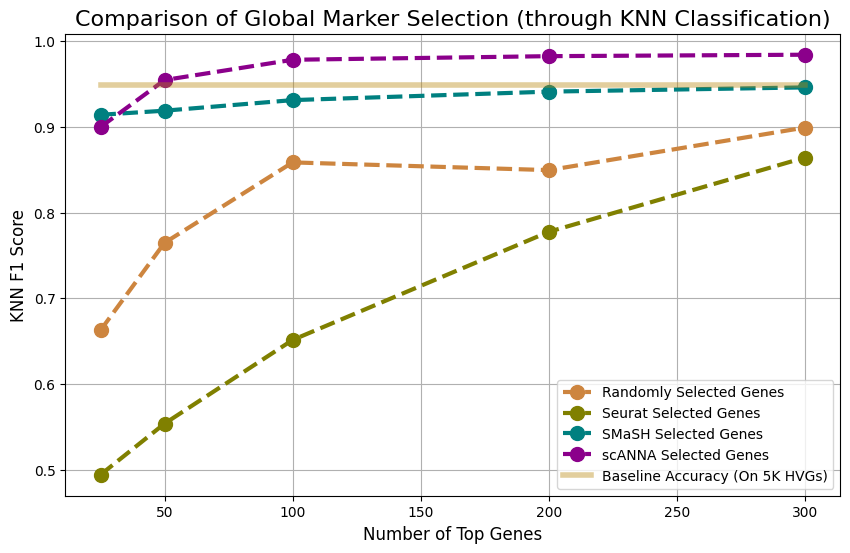

In [22]:
# Set figure default figure size
plt.rcParams["figure.figsize"] = (10, 6)

# Get some random points!
plt.plot(top_n, list(rand_knn_acc_dict.values()), 
         linestyle="--", 
         marker="o", 
         label="Randomly Selected Genes",
         linewidth=3,
         markersize=10,
         color="peru",
         )

plt.plot(top_n, list(seurat_knn_acc_dict.values()), 
         linestyle="--", 
         marker="o", 
         label="Seurat Selected Genes",
         linewidth=3,
         markersize=10,
         color = "olive",
         )

plt.plot(top_n, list(smash_knn_acc_dict.values()), 
         linestyle="--", 
         marker="o", 
         label="SMaSH Selected Genes",
         linewidth=3,
         markersize=10,
         color = "teal"
        )

plt.plot(top_n, list(scanna_knn_acc_dict.values()), 
         linestyle="--", 
         marker="o", 
         label="scANNA Selected Genes",
         linewidth=3,
         markersize=10,
         color = "darkmagenta",
         )

plt.plot(top_n, [knn_5k_accuracy]*len(top_n), 
         linestyle="-",
         label="Baseline Accuracy (On 5K HVGs)",
         linewidth=4,
         alpha = 0.4,
         color = "darkgoldenrod",
         )

plt.xlabel("Number of Top Genes", fontsize=12)
plt.ylabel("KNN F1 Score", fontsize=12)
plt.title("Comparison of Global Marker Selection (through KNN"
          " Classification)",
          fontsize=16,
         )
plt.grid(True)
plt.legend()
plt.show()

### Fraction of Variance Explained

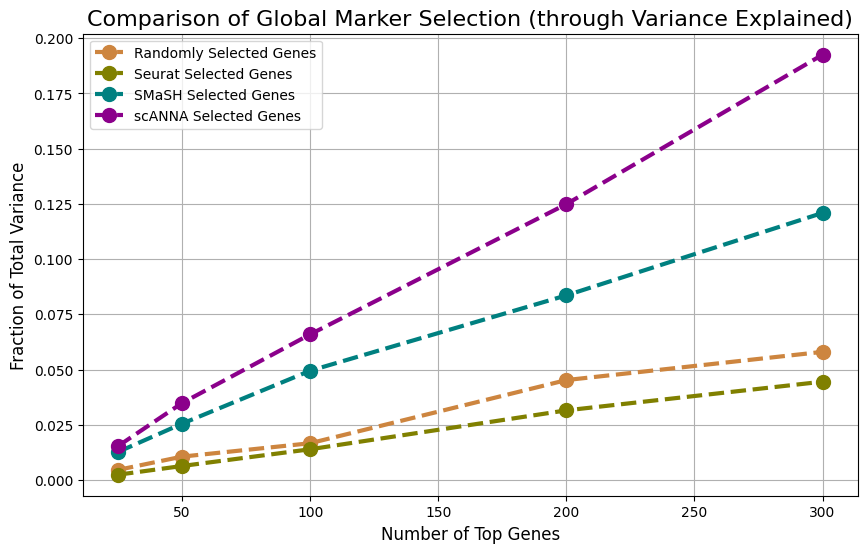

In [24]:
# Set figure default figure size
plt.rcParams["figure.figsize"] = (10, 6)

# Get some random points!
plt.plot(top_n, list(rand_variance_dict.values()), 
         linestyle="--", 
         marker="o", 
         label="Randomly Selected Genes",
         linewidth=3,
         markersize=10,
         color="peru",
         )

plt.plot(top_n, list(seurat_variance_dict.values()), 
         linestyle="--", 
         marker="o", 
         label="Seurat Selected Genes",
         linewidth=3,
         markersize=10,
         color = "olive",
         )

plt.plot(top_n, list(smash_variance_dict.values()), 
         linestyle="--", 
         marker="o", 
         label="SMaSH Selected Genes",
         linewidth=3,
         markersize=10,
         color = "teal"
        )

plt.plot(top_n, list(scanna_variance_dict.values()), 
         linestyle="--", 
         marker="o", 
         label="scANNA Selected Genes",
         linewidth=3,
         markersize=10,
         color = "darkmagenta",
         )


plt.xlabel("Number of Top Genes", fontsize=12)
plt.ylabel("Fraction of Total Variance", fontsize=12)
plt.title("Comparison of Global Marker Selection (through Variance"
          " Explained)",
          fontsize=16,
         )
plt.grid(True)
plt.legend()
plt.show()